# DRAEM Training Dataset Visualization

Compare different blending methods for anomaly generation

In [74]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
from data_loader import MVTecDRAEMTrainDataset
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configuration

In [75]:
obj_name = 'transistor'
data_path = './datasets/mvtec/'
anomaly_source_path = './datasets/dtd/images/'
img_dim = 256
resize_shape = [img_dim, img_dim]
num_samples = 4

## Load Datasets with Different Blending Methods

In [76]:
# Dataset with uniform beta blending (original method)
dataset_uniform = MVTecDRAEMTrainDataset(
    root_dir=data_path + obj_name + "/train/good/",
    anomaly_source_path=anomaly_source_path,
    resize_shape=resize_shape,
    texture_limit=100,
    blend_method='beta_uniform',
    use_image_placeholder=True,
    use_anomaly_placeholder=True,
)

print(f"Uniform beta blending dataset loaded\n")

# Dataset with Perlin noise-based beta blending
dataset_perlin = MVTecDRAEMTrainDataset(
    root_dir=data_path + obj_name + "/train/good/",
    anomaly_source_path=anomaly_source_path,
    resize_shape=resize_shape,
    texture_limit=100,
    blend_method='beta_perlin',
    use_image_placeholder=True,
    use_anomaly_placeholder=True,
)

print(f"Perlin beta blending dataset loaded")
print(f"\nNote: Using gray placeholder images to focus on blending method differences")

Using gray placeholder image (no actual images loaded).
Using pure red anomaly placeholder (no actual anomaly textures loaded).
Uniform beta blending dataset loaded

Using gray placeholder image (no actual images loaded).
Using pure red anomaly placeholder (no actual anomaly textures loaded).
Perlin beta blending dataset loaded

Note: Using gray placeholder images to focus on blending method differences


## Helper Functions

In [77]:
def denormalize_image(img):
    """Convert from (C, H, W) tensor to (H, W, C) numpy array"""
    img = img.numpy() if isinstance(img, torch.Tensor) else img
    img = np.transpose(img, (1, 2, 0))
    return np.clip(img, 0, 1)

def get_samples_with_anomalies(dataset, num_samples=4, max_attempts=100):
    """Get samples that all contain anomalies"""
    samples = []
    attempts = 0
    
    while len(samples) < num_samples and attempts < max_attempts:
        sample = dataset[0]  # Random sample due to dataset implementation
        if sample['has_anomaly'].item() > 0.5:
            samples.append(sample)
        attempts += 1
    
    if len(samples) < num_samples:
        print(f"Warning: Only found {len(samples)} samples with anomalies after {max_attempts} attempts")
    
    return samples

def display_blending_comparison(dataset_uniform, dataset_perlin, num_samples=4):
    """Display samples from both blending methods side-by-side"""
    # Get samples with anomalies
    samples_list = [
        (get_samples_with_anomalies(dataset_uniform, num_samples), 'Uniform Beta', 0),
        (get_samples_with_anomalies(dataset_perlin, num_samples), 'Perlin Beta', num_samples)
    ]
    
    # Create figure: 5 rows x (2 * num_samples) columns
    # First num_samples columns: uniform beta
    # Last num_samples columns: Perlin beta
    # Rows: Clean Image, Anomaly Source, Anomaly Mask, Beta Map, Image with Anomaly
    fig, axes = plt.subplots(5, num_samples * 2, figsize=(num_samples * 6, 15))
    
    # Plot all samples using unified loop
    for samples, method_name, col_offset in samples_list:
        for i, sample in enumerate(samples):
            img_aug = denormalize_image(sample['augmented_image'])
            clean_img = denormalize_image(sample['image'])
            anomaly_source = denormalize_image(sample['anomaly_source_img'])
            mask = denormalize_image(sample['anomaly_mask'])
            beta_map = denormalize_image(sample['beta_map'])
            
            col = col_offset + i
            
            # Row 0: Clean Image
            axes[0, col].imshow(clean_img)
            axes[0, col].set_title(f'{method_name}\nSample {i+1}', fontsize=10, fontweight='bold')
            axes[0, col].axis('off')
            
            # Row 1: Anomaly Source (augmented)
            axes[1, col].imshow(anomaly_source)
            axes[1, col].axis('off')
            
            # Row 2: Anomaly Mask
            axes[2, col].imshow(mask, cmap='hot')
            axes[2, col].axis('off')
            
            # Row 3: Beta Map
            axes[3, col].imshow(beta_map, cmap='viridis', vmin=0, vmax=1)
            axes[3, col].axis('off')
            
            # Row 4: Image with Anomaly
            axes[4, col].imshow(img_aug)
            axes[4, col].axis('off')
    
    # Add row labels on the left
    axes[0, 0].set_ylabel('Clean Image', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Anomaly Source\n(Augmented)', fontsize=12, fontweight='bold')
    axes[2, 0].set_ylabel('Anomaly Mask', fontsize=12, fontweight='bold')
    axes[3, 0].set_ylabel('Beta Map', fontsize=12, fontweight='bold')
    axes[4, 0].set_ylabel('Image with\nAnomaly', fontsize=12, fontweight='bold')
    
    fig.suptitle('Blending Methods: Uniform Beta (left) vs Perlin Beta (right)', 
                 fontsize=14, fontweight='bold', y=0.99)
    
    plt.tight_layout()
    plt.show()

## Blending Method Comparison

Compare uniform beta (constant transparency) vs Perlin beta (spatially-varying transparency).

**Beta Map Explanation:**
- Shows how much the original image contributes to the final blend
- Higher values (yellow in viridis colormap) = more original image visible
- Lower values (purple) = more anomaly texture visible
- Uniform beta: constant value across all pixels
- Perlin beta: spatially-varying with natural Perlin noise patterns

All samples shown contain anomalies.

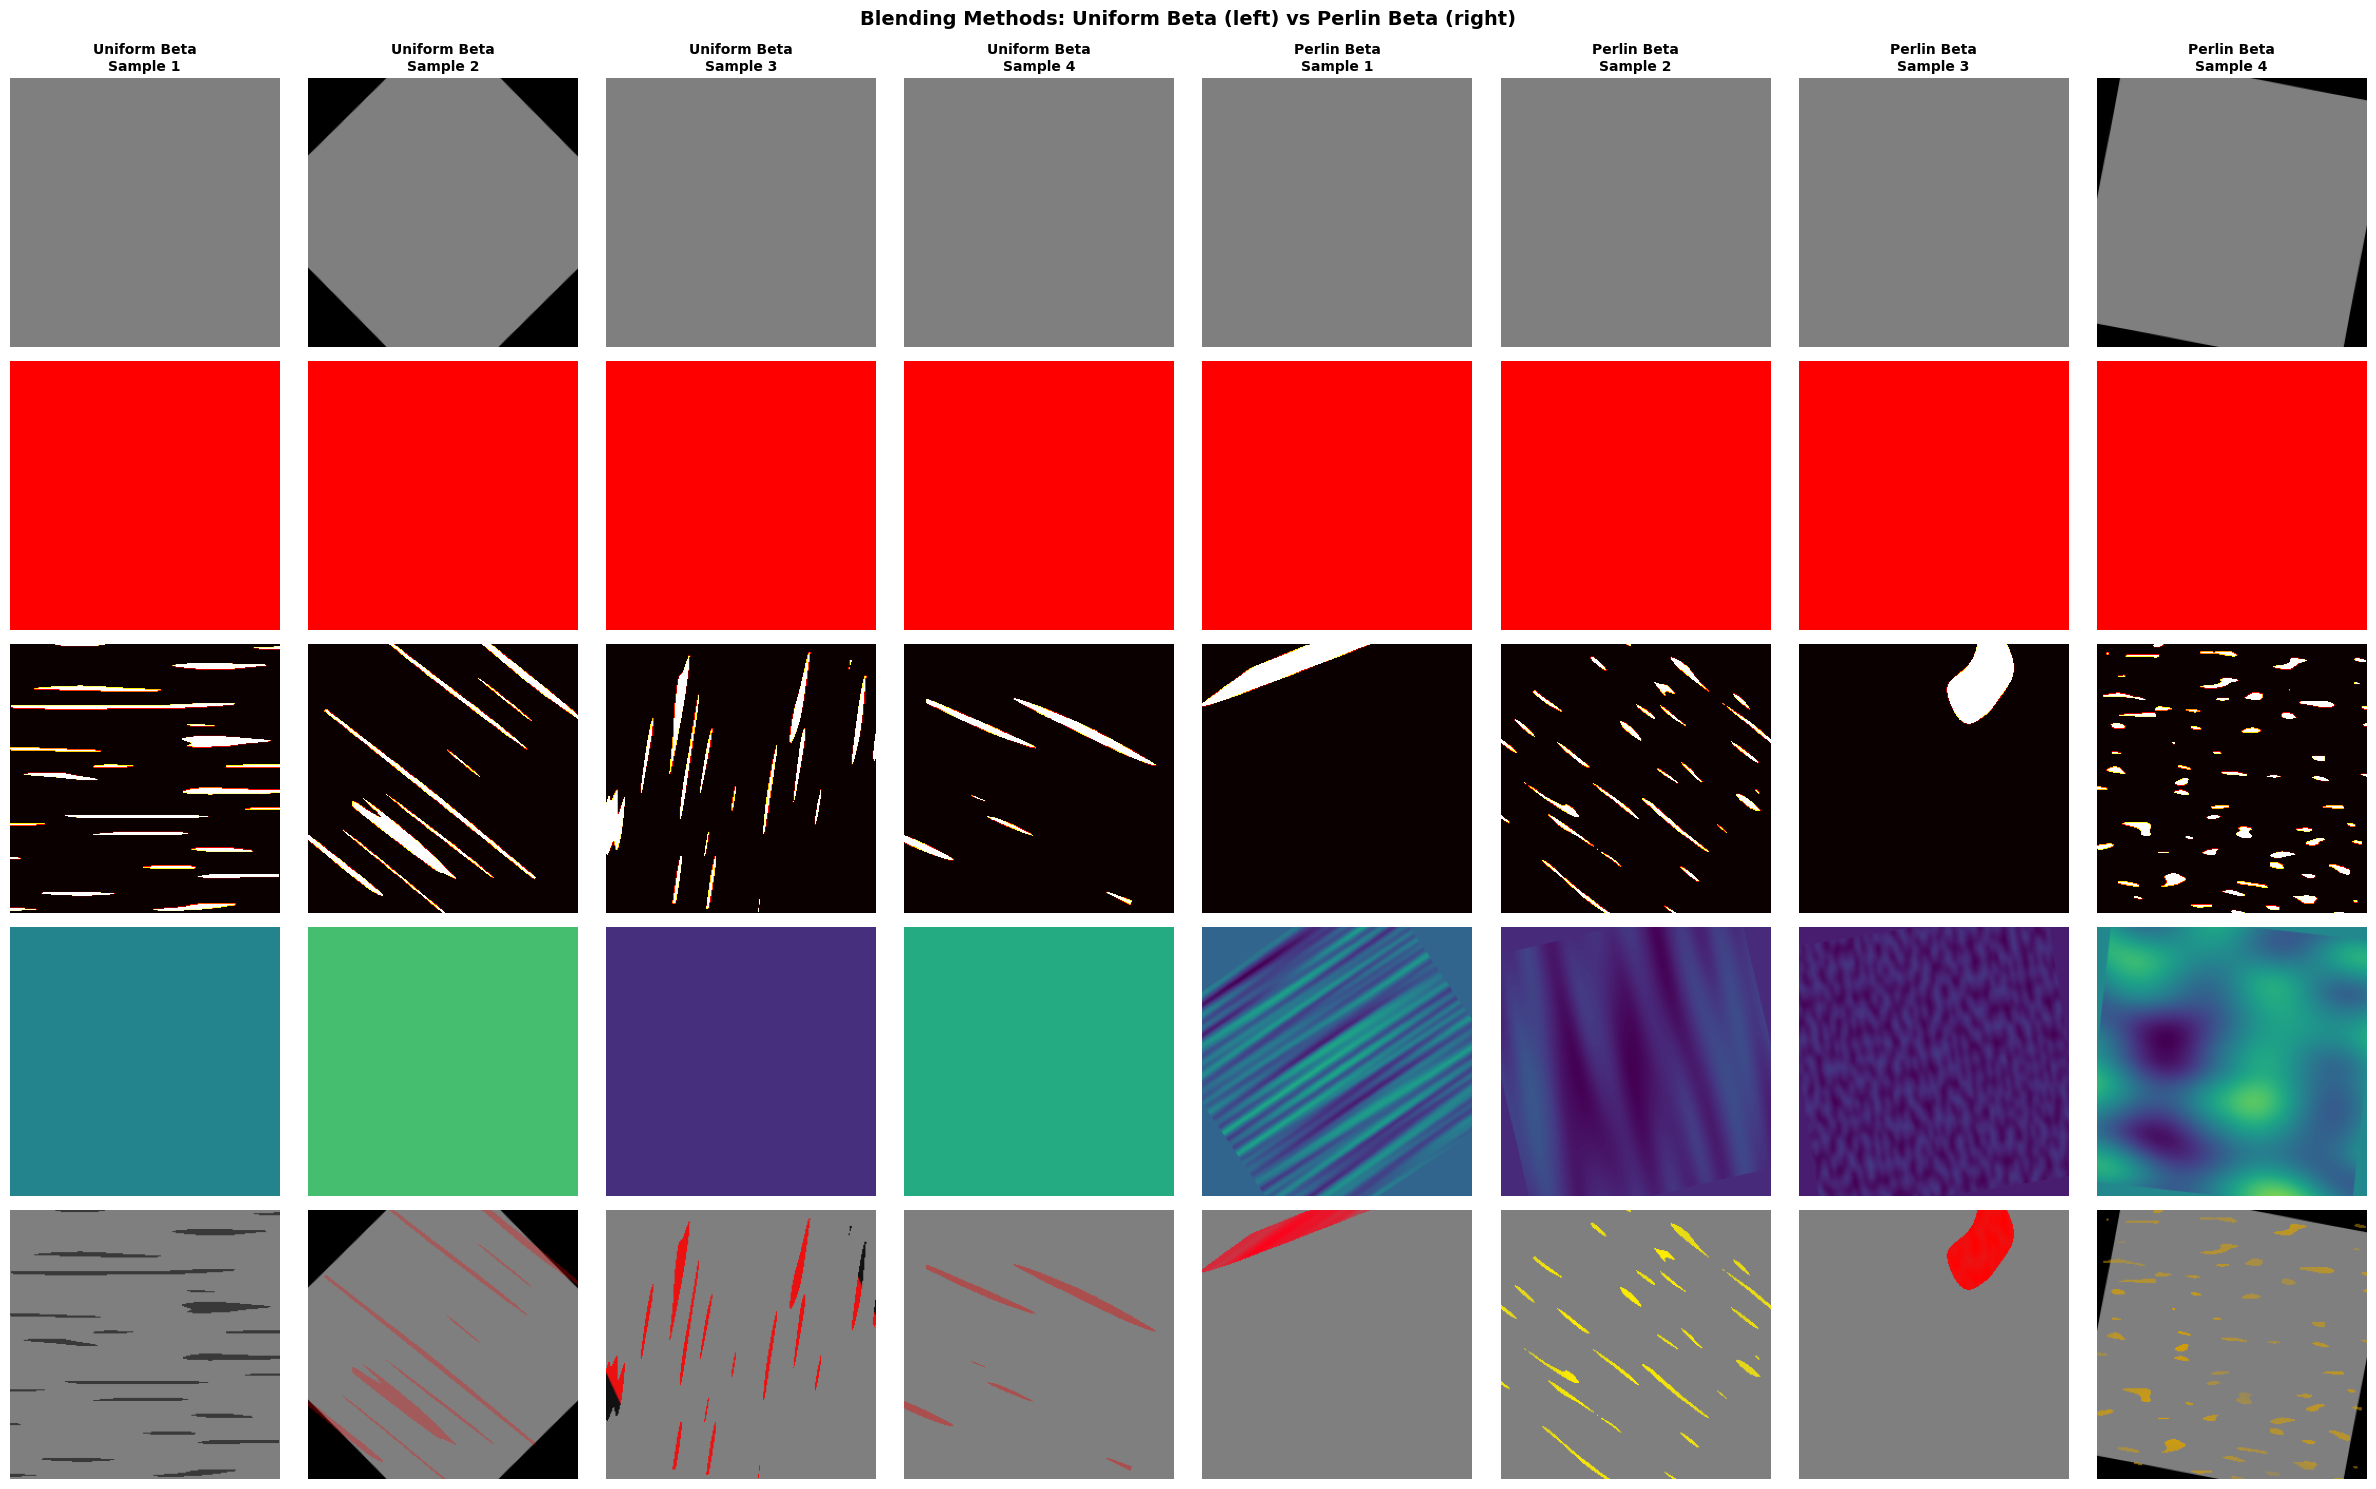

In [79]:
display_blending_comparison(dataset_uniform, dataset_perlin, num_samples)